<a href="https://colab.research.google.com/github/mohd-faizy/09P_Detecting_COVID_19_with_Chest_X-Ray_using_PyTorch/blob/master/01_Detecting_COVID_19_with_Chest_X_Ray_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.5.1+cpu


In [19]:
class_names = ['normal', 'viral', 'covid']
# root_dir = 'COVID-19 Radiography Database'
root_dir = '''C:\\Users\\senga\\OneDrive\\Desktop\\MinorProject\\COVID-19_Radiography_Dataset'''
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    print("maging test folders")
    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    print("Filling test data")
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c,"images")) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c,'images', image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [20]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [21]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [22]:
train_dirs = {
    'normal': f'{root_dir}/normal/images',
    'viral': f'{root_dir}/viral/images',
    'covid': f'{root_dir}/covid/images'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10162 normal examples
Found 1315 viral examples
Found 3586 covid examples


In [23]:
test_dirs = {
    'normal': f'{root_dir}/test/normal',
    'viral': f'{root_dir}/test/viral',
    'covid': f'{root_dir}/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [24]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 2511
Number of test batches 15


In [25]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

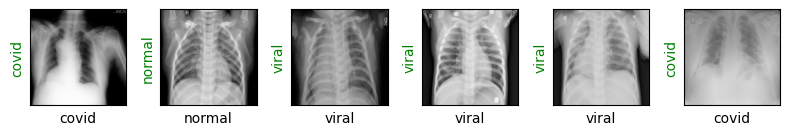

In [26]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

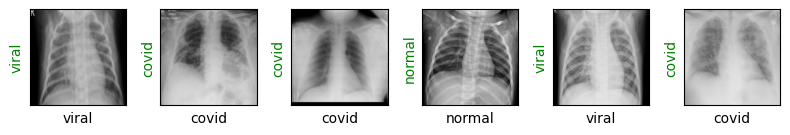

In [27]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

## __Task - 8__ Creating the Model

In [28]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [30]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

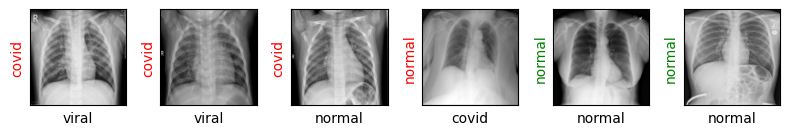

In [31]:
show_preds()

In [32]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.0500, Accuracy: 0.5556


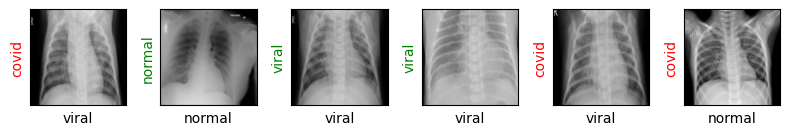

Evaluating at step 20
Validation Loss: 0.8311, Accuracy: 0.7000


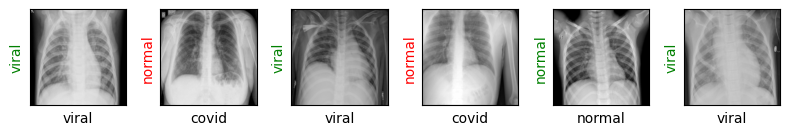

Evaluating at step 40
Validation Loss: 0.6451, Accuracy: 0.7778


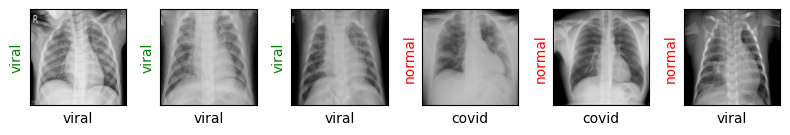

Evaluating at step 60
Validation Loss: 0.5325, Accuracy: 0.8000


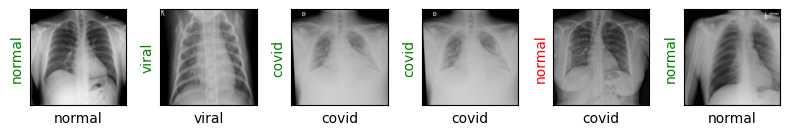

Evaluating at step 80
Validation Loss: 0.3854, Accuracy: 0.8556


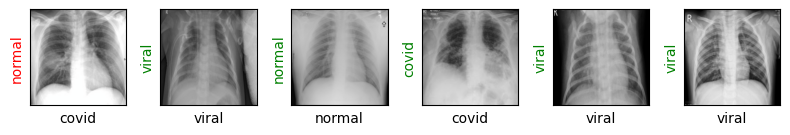

Evaluating at step 100
Validation Loss: 0.3336, Accuracy: 0.8778


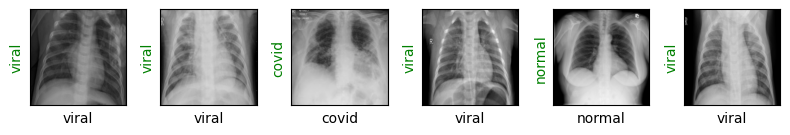

Evaluating at step 120
Validation Loss: 0.3554, Accuracy: 0.8778


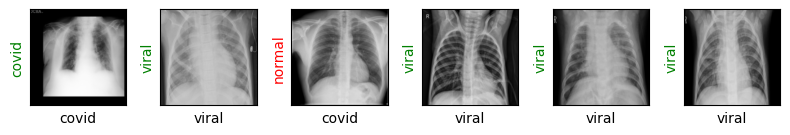

Evaluating at step 140
Validation Loss: 0.2770, Accuracy: 0.9111


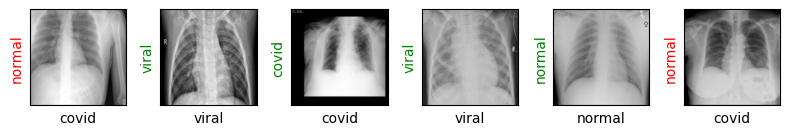

Evaluating at step 160
Validation Loss: 0.3213, Accuracy: 0.9333


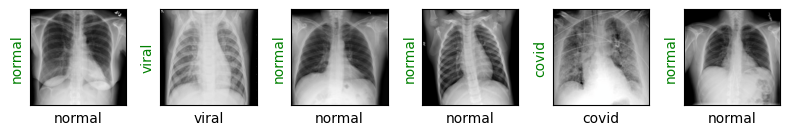

Evaluating at step 180
Validation Loss: 0.4110, Accuracy: 0.8556


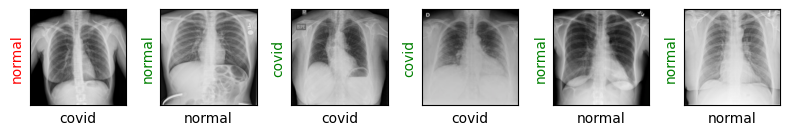

Evaluating at step 200
Validation Loss: 0.2560, Accuracy: 0.9333


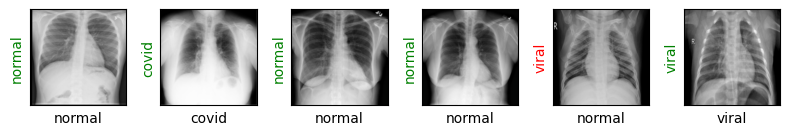

Evaluating at step 220
Validation Loss: 0.2956, Accuracy: 0.8889


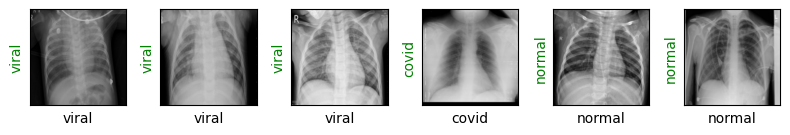

Evaluating at step 240
Validation Loss: 0.1634, Accuracy: 0.9444


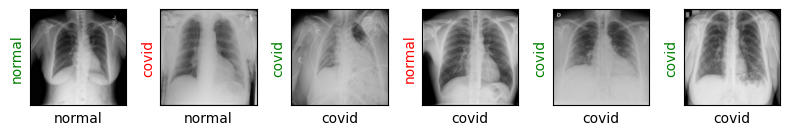

Evaluating at step 260
Validation Loss: 0.2400, Accuracy: 0.9222


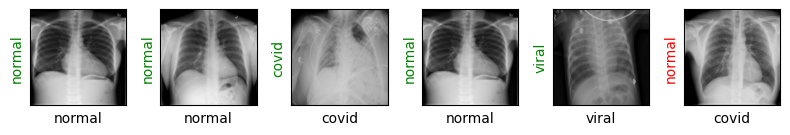

Evaluating at step 280
Validation Loss: 0.2000, Accuracy: 0.9333


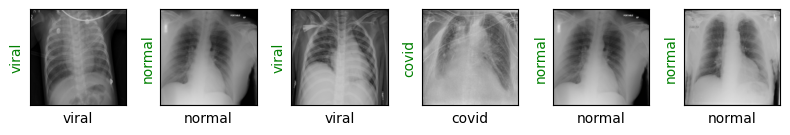

Evaluating at step 300
Validation Loss: 0.2102, Accuracy: 0.9000


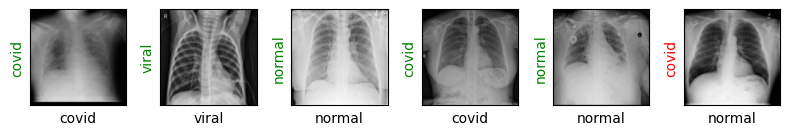

Evaluating at step 320
Validation Loss: 0.1930, Accuracy: 0.9222


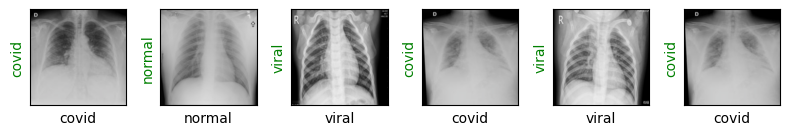

Evaluating at step 340
Validation Loss: 0.2353, Accuracy: 0.9222


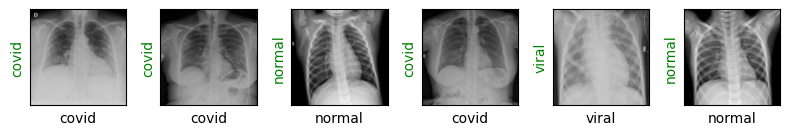

Evaluating at step 360
Validation Loss: 0.2275, Accuracy: 0.9222


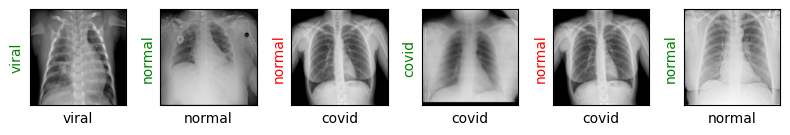

Evaluating at step 380
Validation Loss: 0.2178, Accuracy: 0.9333


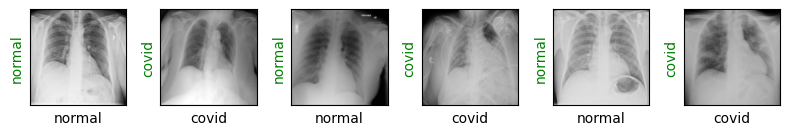

Evaluating at step 400
Validation Loss: 0.2601, Accuracy: 0.9111


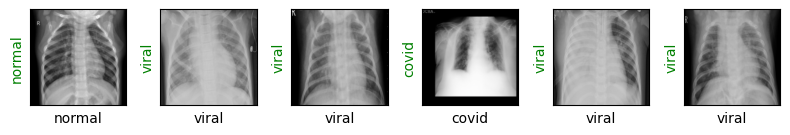

Evaluating at step 420
Validation Loss: 0.2567, Accuracy: 0.9333


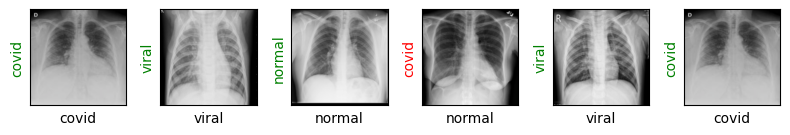

Evaluating at step 440
Validation Loss: 0.2243, Accuracy: 0.8889


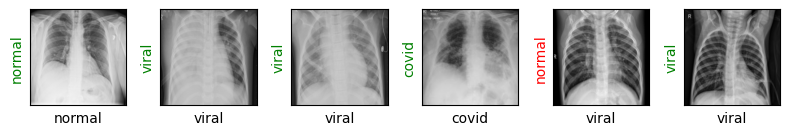

Evaluating at step 460
Validation Loss: 0.2056, Accuracy: 0.9111


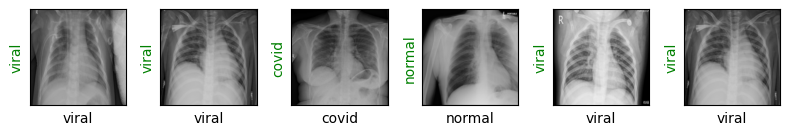

Evaluating at step 480
Validation Loss: 0.2700, Accuracy: 0.8889


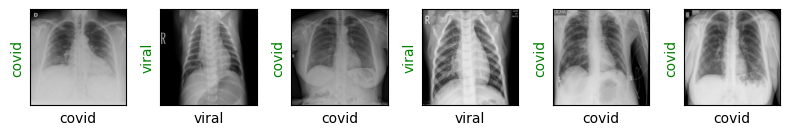

Evaluating at step 500
Validation Loss: 0.3361, Accuracy: 0.8556


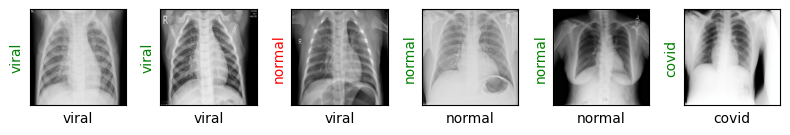

Evaluating at step 520
Validation Loss: 0.1768, Accuracy: 0.9444


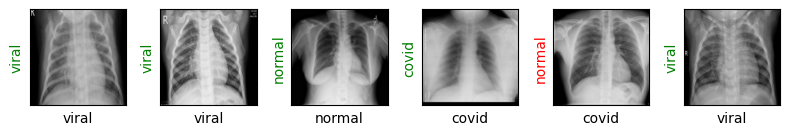

Evaluating at step 540
Validation Loss: 0.1090, Accuracy: 0.9778


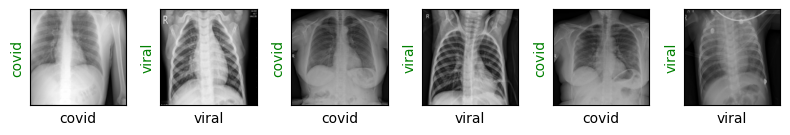

Performance condition satisfied, stopping..
CPU times: total: 38min 25s
Wall time: 22min 51s


In [33]:
%%time

train(epochs=1)

## __Task - 10__ Show the Predictions

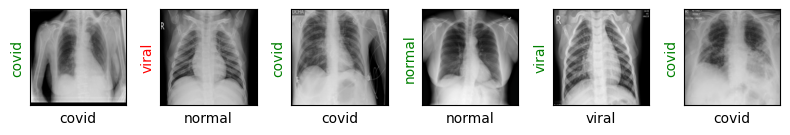

In [34]:
show_preds()

## __Task - 11__ *Saving* the Model

In [35]:
torch.save(resnet18.state_dict(), 'covid_classifier.pt')

## __Task -12__ Inference on a Single Image

In [36]:
# Load the model and set in eval
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

resnet18.load_state_dict(torch.load('covid_classifier.pt'))
resnet18.eval()


def predict_image_class(image_path):
    image = Image.open(image_path).convert('RGB')
    image = test_transform(image)
    # Please note that the transform is defined already in a previous code cell
    image = image.unsqueeze(0)
    output = resnet18(image)[0]
    probabilities = torch.nn.Softmax(dim=0)(output)
    probabilities = probabilities.cpu().detach().numpy()
    predicted_class_index = np.argmax(probabilities)
    predicted_class_name = class_names[predicted_class_index]
    return probabilities, predicted_class_index, predicted_class_name

C:\Users\senga\AppData\Local\Temp\ipykernel_10724\2713111984.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet18.load_state_dict(torch.load('covid_classifier.pt'))


In [37]:
image_path = "C:\\Users\\senga\\OneDrive\\Desktop\\MinorProject\\COVID-19_Radiography_Dataset\\normal\\images\\Normal-3.png"
probabilities, predicted_class_index, predicted_class_name = predict_image_class(image_path)
print('Probabilities:', probabilities)
print('Predicted class index:', predicted_class_index)
print('Predicted class name:', predicted_class_name)

Probabilities: [6.3067830e-01 5.7430286e-04 3.6874735e-01]
Predicted class index: 0
Predicted class name: normal
